In [1]:
import pandas as pd
import seaborn as sns

In [2]:
SHORT_TERM = 25
LONG_TERM = 125

In [75]:
bvsp = pd.read_csv('./BVSP.csv')
bvsp['day'] = pd.to_datetime(bvsp.date)
bvsp = bvsp.drop(['date'], axis=1)
bvsp = bvsp.set_index('day')
bvsp = bvsp[~bvsp.close.isna()]
bvsp.head()

,close
day,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-03-05,24.100000


## Calculando Features

In [76]:
bvsp = bvsp.assign(
    short_min = bvsp.rolling(SHORT_TERM).close.min(),
    short_max = bvsp.rolling(SHORT_TERM).close.max(),
    short_mean = bvsp.rolling(SHORT_TERM).close.mean(),
    
    long_min = bvsp.rolling(LONG_TERM).close.min(),
    long_max = bvsp.rolling(LONG_TERM).close.max(),
    long_mean = bvsp.rolling(LONG_TERM).close.mean()
)
bvsp = bvsp.assign(
    short_noise = (bvsp.close - bvsp.short_mean) / bvsp.short_mean,
    long_noise = (bvsp.close - bvsp.long_mean) / bvsp.long_mean,
)
bvsp = bvsp.assign(
    prev_short_mean = bvsp.short_mean.shift(),
    prev_long_mean = bvsp.long_mean.shift()
)
bvsp = bvsp.assign(
    short_gradient = (bvsp.short_mean - bvsp.prev_short_mean) / bvsp.prev_short_mean,
    long_gradient = (bvsp.long_mean - bvsp.prev_long_mean) / bvsp.prev_long_mean
)

bvsp = bvsp.assign(
    short_rel = (bvsp.close - bvsp.short_min) / (bvsp.short_max - bvsp.short_min),
    long_rel = (bvsp.close - bvsp.long_min) / (bvsp.long_max - bvsp.long_min)
)

bvsp[123:].head(15)

,close,short_min,short_max,short_mean,long_min,long_max,long_mean,short_noise,long_noise,prev_short_mean,prev_long_mean,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,,,,,,,,,,
1993-10-20,166.000000,124.000000,189.399994,154.587999,NaN,NaN,NaN,0.073822,NaN,152.759999,NaN,0.011966,NaN,0.642202,NaN
1993-10-21,150.300003,127.800003,189.399994,155.639999,23.700001,189.399994,78.3352,-0.034310,0.918678,154.587999,NaN,0.006805,NaN,0.365260,0.764031
1993-10-22,166.899994,134.699997,189.399994,157.203999,23.700001,189.399994,79.4744,0.061678,1.100047,155.639999,78.3352,0.010049,0.014543,0.588665,0.864212
1993-10-25,156.100006,134.699997,189.399994,157.892000,23.700001,189.399994,80.5288,-0.011349,0.938437,157.203999,79.4744,0.004376,0.013267,0.391225,0.799034
1993-10-26,164.300003,134.699997,189.399994,158.939999,24.100000,189.399994,81.6536,0.033723,1.012159,157.892000,80.5288,0.006637,0.013968,0.541134,0.848155
1993-10-27,179.800003,136.199997,189.399994,160.744000,24.100000,189.399994,82.8992,0.118549,1.168899,158.939999,81.6536,0.011350,0.015255,0.819549,0.941924
1993-10-28,177.500000,139.100006,189.399994,162.396000,24.600000,189.399994,84.1264,0.093007,1.109920,160.744000,82.8992,0.010277,0.014804,0.763420,0.927791
1993-10-29,184.399994,139.100006,189.399994,164.052000,24.600000,189.399994,85.4024,0.124034,1.159190,162.396000,84.1264,0.010197,0.015168,0.900596,0.969660
1993-01-11,203.600006,139.100006,203.600006,166.488000,25.200001,203.600006,86.8344,0.222911,1.344693,164.052000,85.4024,0.014849,0.016768,1.000000,1.000000


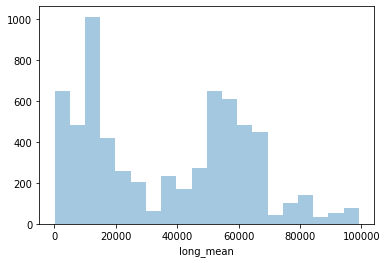